# Assignment 4: Practical Deep Learning for Language Processing (DS405B)
submitted by Tim-Moritz Bündert (ID: 5635975) on February 12, 2022

## Setup

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set data directory
data_dir = "/content/drive/MyDrive/University/DS405B_PDL_for_LP/Assignment_4/"

In [ ]:
!pip install sentence-transformers
!pip install datasets

In [ ]:
# import packages
import numpy as np
import random
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import string
import copy

import torch
from torch.utils.data import DataLoader

from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers.util import cos_sim
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator, CERerankingEvaluator
from sentence_transformers.datasets import NoDuplicatesDataLoader

from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline, AutoModelForSequenceClassification

In [ ]:
device = 'cuda'

## Load dataset

In [ ]:
subjqa = load_dataset('subjqa', name = 'electronics', data_dir = data_dir)
subjqa

Using custom data configuration electronics-70b9d0b6f00a5974
Reusing dataset subjqa (/root/.cache/huggingface/datasets/subjqa/electronics-70b9d0b6f00a5974/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 1295
    })
    test: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 358
    })
    validation: Dataset({
        features: ['domain', 'nn_mod', 'nn_asp', 'query_mod', 'query_asp', 'q_reviews_id', 'question_subj_level', 'ques_subj_score', 'is_ques_subjective', 'review_id', 'id', 'title', 'context', 'question', 'answers'],
        num_rows: 255
    })
})

In [ ]:
# define dataset partitions

subjqa_train = subjqa['train']
subjqa_val = subjqa['validation']
subjqa_test = subjqa['test']

In [ ]:
subjqa_train[1] # print example of training partition to understand its structure 

{'answers': {'ans_subj_score': [0.5083333253860474, 0.5083333253860474],
  'answer_start': [1302, 1302],
  'answer_subj_level': [1, 1],
  'is_ans_subjective': [True, True],
  'text': ['Bass is weak as expected',
   'Bass is weak as expected, even with EQ adjusted up']},
 'context': 'To anyone who hasn\'t tried all the various types of headphones, it is important to remember exactly what these are: cheap portable on-ear headphones. They give a totally different sound then in-ears or closed design phones, but for what they are I would say they\'re good. I currently own six pairs of phones, from stock apple earbuds to Sennheiser HD 518s. Gave my Portapros a run on both my computer\'s sound card and mp3 player, using 256 kbps mp3s or better. The clarity is good and they\'re very lightweight. The folding design is simple but effective. The look is certainly retro and unique, although I didn\'t find it as comfortable as many have claimed. Earpads are *very* thin and made my ears sore after 3

## Exercise 1

In [ ]:
bi_encoder_model = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1', cache_folder = data_dir) # load the bi-encoder

In [ ]:
# create training index of context-embedding pairs 

index_train = []
for example in tqdm(subjqa_train):
  context = example['context']
  context_emb = bi_encoder_model.encode(context)
  index_train.append({'context': context,
                      'embedding': context_emb})

100%|██████████| 1295/1295 [00:18<00:00, 71.79it/s] 


In [ ]:
# create validation index of context-embedding pairs

index_val = []
for example in tqdm(subjqa_val):
  context = example['context']
  context_emb = bi_encoder_model.encode(context)
  index_val.append({'context': context,
                    'embedding': context_emb})

100%|██████████| 255/255 [00:02<00:00, 108.29it/s]


In [ ]:
# create test index of context-embedding pairs

index_test = []
for example in tqdm(subjqa_test):
  context = example['context']
  context_emb = bi_encoder_model.encode(context)
  index_test.append({'context': context,
                     'embedding': context_emb})

100%|██████████| 358/358 [00:03<00:00, 105.99it/s]


## Exercise 2

Two options for fine-tuning the cross-encoder `cross-encoder/ms-marco-MiniLM-L-6- v2` are possible:

1) Using the `Transformers` framework with the `AutoModelForSequenceClassification` class and the "typical" PyTorch way to train a model

2) Using the dedicated `CrossEncoder` class of `SentenceTransformers` with the built-in **.fit()** function.

In the folllowing, both options will be considered and subsequently evaluated in exercise 3 and 4 where it will be then decided with which of the two versions to move on with.

First, the training dataset has to be created. Apart from the original ("gold") training dataset (if query contains an answer: label = 1, if query is unanswerable: label = 0), additional artificial negative examples are constructed by pairing eac query with all other contexts and accordingly assigning a label of 0. Thereby, the MNR loss can be simulated and the training dataset size increased.

In [ ]:
training_dataset_true = []
training_dataset_augmented = []
for i, example_query in tqdm(enumerate(subjqa_train)):
  query = example_query['question']
  for j, example_context in enumerate(index_train):
    context = example_context['context']
    if i == j:
      if len(example_query['answers']['text']) > 0:
        sim = 1.0 # if there is at least one answer in this context: positive example
      else:
        sim = 0.0 # if no answer is present (unanswerable question): negative example
      training_dataset_true.append({'question': query, 'context': context, 'label': sim}) # collect samples that are required to be present in training dataset
    else:
      sim = 0.0
      training_dataset_augmented.append({'question': query, 'context': context, 'label': sim}) # collect artificially created samples

1295it [00:01, 780.74it/s]


With 1295 \* 1294 = 1,675,730 additional negative examples in **training_dataset_augmented**, training on this dataset would be computationally infeasible. Instead, it will be randomly sampled from this collection whereas the number of samples presents a hyperparameter which can be tuned using the validation dataset.

### 1) `Transformers`

In [ ]:
# implement validation set with the same conventions

validation = []
for example in subjqa_val:
  if len(example['answers']['text']) > 0:
    label = 1.0
  else:
    label = 0.0
  validation.append({'question': example['question'], 'context': example['context'], 'label': label})

In [ ]:
def collate_batch_ce(batch):
  input_ids = []
  attention_masks = []
  labels = []
  
  for example in batch:
    # tokenize question and context
    tokenized = cross_encoder_tokenizer(example['question'],
                                        example['context'], 
                                        max_length = 512, 
                                        truncation = True, 
                                        return_tensors = "pt", 
                                        pad_to_max_length = True)

    input_ids.append(tokenized['input_ids'])
    attention_masks.append(tokenized['attention_mask'])
    labels.append(example['label'])

  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  return input_ids, attention_masks, labels

val_dataloader_ce = DataLoader(validation, batch_size = 32, shuffle = True, collate_fn = collate_batch_ce)

In [ ]:
# range for hyperparameter tuning (grid-search)
lr_range = [1e-02, 1e-03]
n_neg_samples = [6000, 8000, 10000]

best_val_loss_overall = 100

for lr in lr_range:
  for neg_samples in n_neg_samples:

    print(f'Selected Learning_rate = {lr}        Number of additional negative samples = {neg_samples}\n')

    # load model and tokenizer
    cross_encoder_model = AutoModelForSequenceClassification.from_pretrained('cross-encoder/ms-marco-MiniLM-L-6-v2', cache_dir = data_dir)
    cross_encoder_tokenizer = AutoTokenizer.from_pretrained('cross-encoder/ms-marco-MiniLM-L-6-v2' , cache_dir = data_dir)

    # construct training dataset
    random.seed(42)
    augmented_training_reduced = random.sample(training_dataset_augmented, neg_samples)
    training_dataset_t = training_dataset_true + augmented_training_reduced
    train_dataloader_ce = DataLoader(training_dataset_t, batch_size = 128, shuffle = True, collate_fn = collate_batch_ce)

    # only re-train the linear pooler and classifier
    for param in cross_encoder_model.parameters():
      param.requires_grad = False

    for param in cross_encoder_model.bert.pooler.parameters():
      param.requires_grad = True

    for param in cross_encoder_model.classifier.parameters():
      param.requires_grad = True

    cross_encoder_model = cross_encoder_model.to(device)
    optimizer = torch.optim.Adam(cross_encoder_model.parameters(), lr=lr)

    num_epochs = 8
    best_val_loss = 100 # set so high such that learning does not break after first epoch

    for epoch in range(num_epochs): 
      running_loss_train = []
      cross_encoder_model.train()
      for batch_train in tqdm(train_dataloader_ce):
        optimizer.zero_grad()

        outputs = cross_encoder_model(input_ids = batch_train[0].to(device),
                                      attention_mask = batch_train[1].to(device),
                                      labels = batch_train[2].to(device))
        
        outputs.loss.backward()

        optimizer.step()
        running_loss_train.append(outputs.loss.item())

      # evaluate the fine-tuned model
      cross_encoder_model.eval()
      running_loss_val = []
      with torch.no_grad():
        for batch_val in val_dataloader_ce:
          outputs = cross_encoder_model(input_ids = batch_val[0].to(device),
                                        attention_mask = batch_val[1].to(device),
                                        labels = batch_val[2].to(device))
          
          running_loss_val.append(outputs.loss.item())

      val_loss = np.mean(running_loss_val)
      
      print(f'Epoch {epoch + 1}:\nTraining Loss = {np.mean(running_loss_train)}   Validation Loss = {val_loss}\n')

      if val_loss < best_val_loss:
        cross_encoder_model_t_best = cross_encoder_model # best model over all epochs
        best_val_loss = val_loss

      else:
        break # early stopping

    if best_val_loss < best_val_loss_overall:
      best_val_loss_overall = best_val_loss
      cross_encoder_model_t = cross_encoder_model_t_best # best model over all hyperparameters
      best_training_dataset_t = training_dataset_t # capture "best" training dataset for subsequent use
      print('Tuned cross encoder model updated.')

    print('------------------------------------\n')

Selected Learning_rate = 0.01        Number of additional negative samples = 6000



  0%|          | 0/57 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 1:
Training Loss = 2.5169146952399037   Validation Loss = 0.41372131928801537



100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 2:
Training Loss = 0.072575297762166   Validation Loss = 0.3542720712721348



100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 3:
Training Loss = 0.06744041306930676   Validation Loss = 0.3775008525699377

Tuned cross encoder model updated.
------------------------------------

Selected Learning_rate = 0.01        Number of additional negative samples = 8000



100%|██████████| 73/73 [01:25<00:00,  1.17s/it]


Epoch 1:
Training Loss = 1.8994470891887194   Validation Loss = 0.3212188482284546



100%|██████████| 73/73 [01:25<00:00,  1.17s/it]


Epoch 2:
Training Loss = 0.05476142828391023   Validation Loss = 0.3242396414279938

Tuned cross encoder model updated.
------------------------------------

Selected Learning_rate = 0.01        Number of additional negative samples = 10000



100%|██████████| 89/89 [01:43<00:00,  1.17s/it]


Epoch 1:
Training Loss = 1.638687427767835   Validation Loss = 0.3477076254785061



100%|██████████| 89/89 [01:43<00:00,  1.16s/it]


Epoch 2:
Training Loss = 0.04492150418711512   Validation Loss = 0.34807523526251316

------------------------------------

Selected Learning_rate = 0.001        Number of additional negative samples = 6000



100%|██████████| 57/57 [01:07<00:00,  1.18s/it]


Epoch 1:
Training Loss = 5.1495180106476734   Validation Loss = 0.46664974093437195



100%|██████████| 57/57 [01:07<00:00,  1.18s/it]


Epoch 2:
Training Loss = 0.13222213442388334   Validation Loss = 0.3212033826857805



100%|██████████| 57/57 [01:06<00:00,  1.17s/it]


Epoch 3:
Training Loss = 0.09565266437436405   Validation Loss = 0.31710853427648544



100%|██████████| 57/57 [01:07<00:00,  1.18s/it]


Epoch 4:
Training Loss = 0.08065850300747052   Validation Loss = 0.32728779688477516

Tuned cross encoder model updated.
------------------------------------

Selected Learning_rate = 0.001        Number of additional negative samples = 8000



100%|██████████| 73/73 [01:25<00:00,  1.17s/it]


Epoch 1:
Training Loss = 3.9621208638769305   Validation Loss = 0.30178481340408325



100%|██████████| 73/73 [01:25<00:00,  1.17s/it]


Epoch 2:
Training Loss = 0.10040336260444498   Validation Loss = 0.3317076005041599

Tuned cross encoder model updated.
------------------------------------

Selected Learning_rate = 0.001        Number of additional negative samples = 10000



100%|██████████| 89/89 [01:43<00:00,  1.17s/it]


Epoch 1:
Training Loss = 3.3618229365583217   Validation Loss = 0.34776404686272144



100%|██████████| 89/89 [01:43<00:00,  1.17s/it]


Epoch 2:
Training Loss = 0.07899586843808046   Validation Loss = 0.3408302888274193



100%|██████████| 89/89 [01:43<00:00,  1.17s/it]


Epoch 3:
Training Loss = 0.059072932479589176   Validation Loss = 0.3470219187438488

------------------------------------



Hence, the best result was achieved using a learning rate of 0.001 and 8,000 additional negative samples after one epoch. Therefore, these values will be stored.

In [ ]:
epochs_ce_tuned = 1
lr_ce_tuned = 0.001

### 2) `SentenceTransformers`

Using `SententenceTransformers`, the **CERerankingEvaluator** can be used to evaluate the fine-tuned model for the specific application of re-ranking. To set this Evaluator up, each answerable query along with its positive context will be paired with all other contexts which serve as the negative ones.

Also, the best training dataset from the `Transformers` approach is used (and converted) for this approach as well such that the two methods are comparable.

In [ ]:
eval_samples = []
all_val_contexts = [example['context'] for example in subjqa_val]
for example in subjqa_val:
  if len(example['answers']['text']) > 0:
    query = example['question']
    pos_context = example['context']
    neg_contexts = copy.deepcopy(all_val_contexts)
    neg_contexts.remove(pos_context)
    eval_samples.append({'query': query, 'positive': [pos_context], 'negative': neg_contexts})
  else:
    continue

evaluator = CERerankingEvaluator(eval_samples)

training_dataset_st = [InputExample(texts = [example['question'], example['context']], label = int(example['label'])) for example in best_training_dataset_t]
training_dataloader_st = DataLoader(training_dataset_st, batch_size = 16) # smaller batch size due to memory constraints

Since it is more difficult to evaluate the best hyperparameters for the `SentenceTransformers` approach (ideas can be seen under the sub-section **Additional considerations**), the hyperparameters from the `Transformers` approach are used (acknowledging that this biases the comparison to some extent).

Also, overfitting is not an issue here because the evaluator automatically selects the best trained model.

In [ ]:
cross_encoder_model_st = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2', num_labels = 1)
cross_encoder_model_st.fit(train_dataloader = training_dataloader_st,
                           evaluator = evaluator,
                           epochs = epochs_ce_tuned,
                           evaluation_steps = int(len(training_dataloader_st) / 2), # evaluate after half of an epoch
                           optimizer_class = torch.optim.Adam,
                           optimizer_params = {'lr': lr_ce_tuned}, # use fine-tuned learning rate from Transformers method
                           warmup_steps = int(len(training_dataloader_st)*0.1),
                           show_progress_bar = True)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/581 [00:00<?, ?it/s]

### Additional considerations

In this subsection, some further ideas/ experiments that took place in connection to the fine-tuning of the cross-encoder are presented.

First, several ideas with regard to the fine-tuning of the `SentenceTransformers` method were evaluated. Below, both an approach to use the **BCEWithLogitsLoss** and using the re-ranking error are displayed.

Both methods were also employed with the model, but did not yield comparably good results and therefore, these approaches were not considered for the final version.

In [ ]:
# 1) BCEWithLogitsLoss()
outputs = torch.tensor(cross_encoder_model.predict([[subjqa_val[i]['question'], subjqa_val[i]['context']] for i in range(len(subjqa_val))]))
# set up 'targets' as corresponding 0-1 vector with regard to whether answer is present in example or not
loss = torch.nn.BCEWithLogitsLoss()
loss_epoch = loss(outputs, targets)

# 2) Re-ranked index as loss
loss = 0
for n, example in enumerate(subjqa_val):
  scores = cross_encoder_model.predict([[example['question'], subjqa_val[i]['context']] for i in range(len(subjqa_val))])
  ranking_index = np.array(scores).argsort()[::-1]
  result = list(ranking_index).index(n) # loss of training example is its position after re-ranking
  loss += result

In addition, several different ideas to construct the training dataset were tried out. 

The first method does not select random artifical negative samples, but rather takes the ten contexts for each query, which yielded the highest cosine similarity. Thereby, the intention was to feed the model those prime negative examples which are supposed to be extremely hard and may be helpful for the model.

Second, it was also evaluated to not assign hard labels to the positive and negative examples, but rather use the cosine similarity of the bi-encoder embeddings.

Eventually, both approaches did not result in any performance gains, but rather yielded worse results and were therefore not considered any further.

In [ ]:
# 1) Prime negative examples
training_dataset_augmented = []

for sample in tqdm(subjqa_train):
  if len(sample['answers']['text']) > 0:
    query = sample['question']
    context = sample['context']

    # use bi-encoder to retrieve top 10 contexts with highest cosine similaritity
    query_emb = bi_encoder_model.encode(query)
    cos_similarities = [cos_sim(query_emb, context['embedding']) for context in index_train]
    
    rel_contexts = np.array(cos_similarities).argsort()[-10:][::-1]
    contexts = [index_train[rel_context]['context'] for rel_context in rel_contexts]
    if context in contexts:
      contexts.remove(context)

    for c in contexts:
        training_dataset_augmented.append(InputExample(texts = [query, c], label = 0))

# 2) Cosine similarity as soft label
sim = (cos_sim(query_emb, example_context['embedding']) + 1) / 2 # normalize cosine similarity to (0,1)

100%|██████████| 1295/1295 [03:07<00:00,  6.92it/s]


## Exercise 3


In [ ]:
test_results_t = []
test_results_st = []

for sample in tqdm(subjqa_test):
  query = sample['question']

  # use bi-encoder to retrieve top n (30) contexts with highest cosine similaritity (as experiments showed that n = 30 performs better than n = 10)
  query_emb = bi_encoder_model.encode(query)
  cos_similarities = [cos_sim(query_emb, context['embedding']) for context in index_test]
  rel_contexts = np.array(cos_similarities).argsort()[-30:][::-1]


  # use fine-tuned cross-encoders to re-rank those relevant contexts
  ## 1) Transformers approach
  scores_t = []
  cross_encoder_model_t.eval()
  with torch.no_grad():
    for context_id in rel_contexts:
      tokenized = cross_encoder_tokenizer(query, 
                                          index_test[context_id]['context'], 
                                          truncation = 'only_second',
                                          max_length = 512, 
                                          return_tensors = "pt", 
                                          pad_to_max_length = True).to(device)

      scores_t.append(cross_encoder_model_t(**tokenized).logits)
  ranked_contexts_t = np.array(scores_t).argsort()[::-1] # re-rank contexts
  result_t = [{'context': index_test[rel_contexts[rank]]['context'], 'score': scores_t[rank]} for rank in ranked_contexts_t]
  test_results_t.append(result_t)


  ## 2) SentenceTransformers approach
  scores_st = [cross_encoder_model_st.predict([(query, index_test[rel_context]['context'])])[0] for rel_context in rel_contexts]
  ranked_contexts_st = np.array(scores_st).argsort()[::-1] # re-rank contexts
  result_st = [{'context': index_test[rel_contexts[rank]]['context'], 'score': scores_st[rank]} for rank in ranked_contexts_st]
  test_results_st.append(result_st)

  0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 358/358 [03:26<00:00,  1.73it/s]


## Exercise 4

In [ ]:
def recall_test_samples(test_results, k = 10):
  counter = 0
  num_tests = 0
  for i, sample in enumerate(subjqa_test):
    if len(sample['answers']['text']) > 0: # remove unanswerable examples from evaluation
      num_tests += 1
      answer = sample['context'] # select correct context
      results = test_results[i]
      rel_contexts = [results[j]['context'] for j in range(k)] 
      if answer in rel_contexts: # evaluate whether correct context is among the k best reranked ones
        counter += 1

  return counter / num_tests

In [ ]:
k_range = np.arange(len(test_results_t[0])) + 1 # evaluate for each possible k within n (gives a more detailed view than only k = 1,3,5,10)

recalls_test_t = [recall_test_samples(test_results_t, k) for k in k_range] # evaluate for Transformers approach
recalls_test_st = [recall_test_samples(test_results_st, k) for k in k_range] # evaluate for SentenceTransformers approach

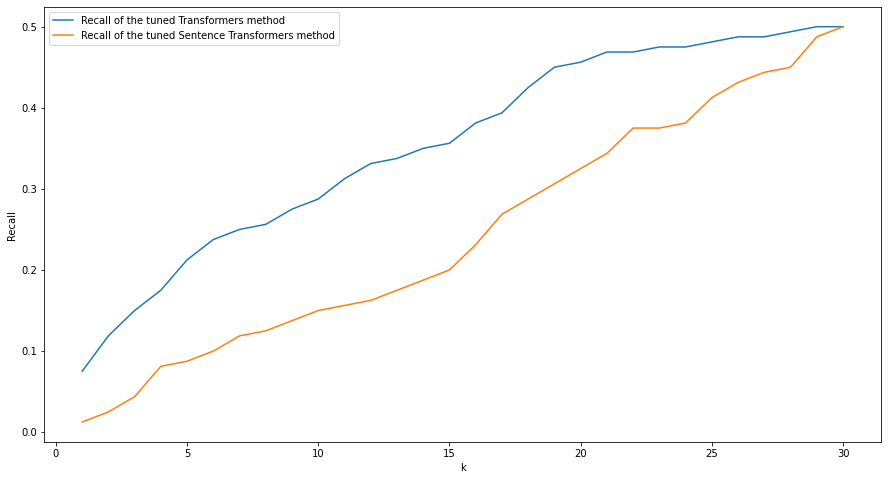

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(k_range, recalls_test_t, label = 'Recall of the tuned Transformers method')
plt.plot(k_range, recalls_test_st, label = 'Recall of the tuned Sentence Transformers method') 
plt.xlabel("k")
plt.ylabel("Recall")
plt.legend()
plt.show()

Analyzing the graph, it can be seen that the `Transformers` approach consistently outperforms the `SentenceTransformer` one. However, this was somehow expected due to the introduced bias when selecting the hyperparameters. 

Since we trained the cross-encoder to potentially reduce k while maintaining a high recall, **k = 20** is selected because there, recall performance begins to saturate. While this increase in k compared to k = 10 will result in a slower final reader step, it is reasonable given the recall performance to ensure that the correct context is present among the selected ones.

Also, as **n = 30** worked reasonably well, this parameter is also set.

In [ ]:
k_best = 20
n_best = 30

## Exercise 5

In [ ]:
def collate_batch_reader(batch):
  input_ids = []
  attention_masks = []
  token_type_ids = []
  start_pos = []
  end_pos = []

  for example in batch:

    tokenized = reader_tokenizer(example['question'], 
                                 example['context'], 
                                 return_overflowing_tokens = True, 
                                 max_length = 512, 
                                 stride = stride_selected, 
                                 return_tensors = "pt", 
                                 pad_to_max_length = True, 
                                 return_offsets_mapping = True,  # return (char_start, char_end) for each token
                                 truncation = False)
    
    for i, offset in enumerate(tokenized["offset_mapping"]): # go through different parts (windows) of example produced by stride
      sequence_ids = tokenized.sequence_ids(i)

      # find context of this window
      idx = 0
      while sequence_ids[idx] != 1:
          idx += 1
      context_start = idx
      while sequence_ids[idx] == 1:
          idx += 1
      context_end = idx - 1 # last index was the last one of this window

      # if example contains no answer: label with CLS token
      if len(example['answers']['answer_start']) == 0:
        input_ids.append(tokenized['input_ids'][i].unsqueeze(0))
        attention_masks.append(tokenized['attention_mask'][i].unsqueeze(0))
        token_type_ids.append(tokenized['token_type_ids'][i].unsqueeze(0))
        start_pos.append(0)
        end_pos.append(0)

      else:
        found_start = []
        found_end = []
        for answer_nr in range(len(example['answers']['answer_start'])): # iterate through all answers of example
          start_char = example['answers']['answer_start'][answer_nr]
          end_char = example['answers']['answer_start'][answer_nr] + len(example['answers']['text'][answer_nr])

          if offset[context_start][0] > end_char or offset[context_end][1] < start_char: # check whether answer is not fully in span of context (on character-level)
            continue
            
          else:
            # find start and end token positions (mapping from their character positions to indices)
            start_idx = context_start
            while start_idx <= context_end and offset[start_idx][0] <= start_char:
                start_idx += 1
            found_start.append(start_idx - 1) # remove the last step

            end_idx = context_end
            while end_idx >= context_start and offset[end_idx][1] >= end_char:
                end_idx -= 1
            found_end.append(end_idx + 1) # remove the last step

        if len(found_start) > 0: # if found answer(s) in context span: add it/them to training data
          for answer in range(len(found_start)):
            input_ids.append(tokenized['input_ids'][i].unsqueeze(0))
            attention_masks.append(tokenized['attention_mask'][i].unsqueeze(0))
            token_type_ids.append(tokenized['token_type_ids'][i].unsqueeze(0))
            start_pos.append(found_start[answer])
            end_pos.append(found_end[answer])

        else: # if no answer is (fully) in span of context: label is (0,0)
          input_ids.append(tokenized['input_ids'][i].unsqueeze(0))
          attention_masks.append(tokenized['attention_mask'][i].unsqueeze(0))
          token_type_ids.append(tokenized['token_type_ids'][i].unsqueeze(0))
          start_pos.append(0)
          end_pos.append(0)


  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  token_type_ids = torch.cat(token_type_ids, dim=0)
  start_pos = torch.tensor(start_pos)
  end_pos = torch.tensor(end_pos)

  return input_ids, token_type_ids, attention_masks, start_pos, end_pos


train_dataloader_reader = DataLoader(subjqa_train, batch_size = 32, shuffle = True, collate_fn = collate_batch_reader)
val_dataloader_reader = DataLoader(subjqa_val, batch_size = 32, shuffle = True, collate_fn = collate_batch_reader)

In [ ]:
# hyperparameter to be tuned (grid-search)
stride_range = [50, 100, 150]
lr_range = [1e-3, 1e-4]

best_val_loss_overall = 4

for stride_selected in stride_range:
  for lr_selected in lr_range:
    print(f'Selected stride = {stride_selected}    Selected Learning_rate = {lr_selected}\n')

    # load model and tokenizer
    reader_model = AutoModelForQuestionAnswering.from_pretrained("deepset/minilm-uncased-squad2", cache_dir = data_dir)
    reader_tokenizer = AutoTokenizer.from_pretrained("deepset/minilm-uncased-squad2", cache_dir = data_dir)

    # since we cannot train all parameters (results in CUDA out of memory), we only fine-tune the final linear layer (and not the BERT corpus)
    for param in reader_model.parameters():
      param.requires_grad = False

    for param in reader_model.bert.encoder.layer[len(reader_model.bert.encoder.layer) - 1].output.parameters():
      param.requires_grad = True

    for param in reader_model.bert.encoder.layer[len(reader_model.bert.encoder.layer) - 2].output.parameters():
      param.requires_grad = True

    for param in reader_model.bert.encoder.layer[len(reader_model.bert.encoder.layer) - 3].output.parameters():
      param.requires_grad = True

    for param in reader_model.qa_outputs.parameters():
        param.requires_grad = True


    reader_model = reader_model.to(device)
    optimizer = torch.optim.Adam(reader_model.parameters(), lr = lr_selected)

    num_epochs = 20
    best_val_loss = 4

    for epoch in range(num_epochs): 
      running_loss_train = []
      reader_model.train()
      for batch_train in tqdm(train_dataloader_reader):
        optimizer.zero_grad()

        outputs = reader_model(input_ids = batch_train[0].to(device),
                              token_type_ids = batch_train[1].to(device),
                              attention_mask = batch_train[2].to(device),
                              start_positions = batch_train[3].to(device), 
                              end_positions = batch_train[4].to(device))
        
        outputs.loss.backward()
        optimizer.step() # fine-tuning
        running_loss_train.append(outputs.loss.item())

      reader_model.eval()
      running_loss_val = []
      with torch.no_grad():
        for batch_val in val_dataloader_reader:
          outputs = reader_model(input_ids = batch_val[0].to(device),
                                token_type_ids = batch_val[1].to(device),
                                attention_mask = batch_val[2].to(device),
                                start_positions = batch_val[3].to(device), 
                                end_positions = batch_val[4].to(device))
          
          running_loss_val.append(outputs.loss.item())

      val_loss = np.mean(running_loss_val)

      print(f'Epoch {epoch + 1}:\nTraining Loss = {np.mean(running_loss_train)}   Validation Loss = {val_loss}\n')

      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_reader_model_config = reader_model # best model over all epochs

      else:
        break

    if best_val_loss < best_val_loss_overall:
      best_val_loss_overall = best_val_loss
      tuned_reader_model = best_reader_model_config # best model over all hyperparameters
      print('Tuned reader model updated.')

    print('------------------------------------\n')

Selected stride = 50    Selected Learning_rate = 0.001



  0%|          | 0/41 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 41/41 [00:40<00:00,  1.00it/s]


Epoch 1:
Training Loss = 2.4393682828763636   Validation Loss = 2.1185587495565414



100%|██████████| 41/41 [00:39<00:00,  1.03it/s]


Epoch 2:
Training Loss = 2.2706704604916457   Validation Loss = 2.091582641005516



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


Epoch 3:
Training Loss = 2.1834744331313343   Validation Loss = 2.0783803164958954



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


Epoch 4:
Training Loss = 2.1611015738510506   Validation Loss = 2.1552266776561737

Tuned reader model updated.
------------------------------------

Selected stride = 50    Selected Learning_rate = 0.0001



100%|██████████| 41/41 [00:40<00:00,  1.00it/s]


Epoch 1:
Training Loss = 2.5436279453882356   Validation Loss = 2.1941229104995728



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


Epoch 2:
Training Loss = 2.3575232174338363   Validation Loss = 2.1882901191711426



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


Epoch 3:
Training Loss = 2.3193784632333894   Validation Loss = 2.1245640367269516



100%|██████████| 41/41 [00:40<00:00,  1.02it/s]


Epoch 4:
Training Loss = 2.2677489315591206   Validation Loss = 2.111422821879387



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


Epoch 5:
Training Loss = 2.2639458877284353   Validation Loss = 2.1683113425970078

------------------------------------

Selected stride = 100    Selected Learning_rate = 0.001



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


Epoch 1:
Training Loss = 2.4344759481709177   Validation Loss = 2.1162086725234985



100%|██████████| 41/41 [00:40<00:00,  1.01it/s]


Epoch 2:
Training Loss = 2.287447408932011   Validation Loss = 2.072997957468033



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


Epoch 3:
Training Loss = 2.2045119913612923   Validation Loss = 2.051096647977829



100%|██████████| 41/41 [00:41<00:00,  1.00s/it]


Epoch 4:
Training Loss = 2.1353143918805007   Validation Loss = 2.1085850447416306

Tuned reader model updated.
------------------------------------

Selected stride = 100    Selected Learning_rate = 0.0001



100%|██████████| 41/41 [00:41<00:00,  1.01s/it]


Epoch 1:
Training Loss = 2.552847635455248   Validation Loss = 2.194033235311508



100%|██████████| 41/41 [00:40<00:00,  1.00it/s]


Epoch 2:
Training Loss = 2.359352443276382   Validation Loss = 2.140195056796074



100%|██████████| 41/41 [00:41<00:00,  1.00s/it]


Epoch 3:
Training Loss = 2.311724217926584   Validation Loss = 2.0917259007692337



100%|██████████| 41/41 [00:41<00:00,  1.00s/it]


Epoch 4:
Training Loss = 2.2935649505475673   Validation Loss = 2.1084565222263336

------------------------------------

Selected stride = 150    Selected Learning_rate = 0.001



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


Epoch 1:
Training Loss = 2.435458974140446   Validation Loss = 2.0485027134418488



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


Epoch 2:
Training Loss = 2.3054281211480863   Validation Loss = 2.0561772286891937

Tuned reader model updated.
------------------------------------

Selected stride = 150    Selected Learning_rate = 0.0001



100%|██████████| 41/41 [00:42<00:00,  1.03s/it]


Epoch 1:
Training Loss = 2.542048221681176   Validation Loss = 2.18615061044693



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


Epoch 2:
Training Loss = 2.347098591851025   Validation Loss = 2.134584456682205



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


Epoch 3:
Training Loss = 2.3102754325401493   Validation Loss = 2.0737644881010056



100%|██████████| 41/41 [00:41<00:00,  1.02s/it]


Epoch 4:
Training Loss = 2.2885160824147666   Validation Loss = 2.078025236725807

------------------------------------



In [ ]:
tuned_stride = 150 # save the tuned stride for subsequent usage in exercise 6)

### Additional Considerations

Performing a sample application of question answering (see below), it can be seen that the dataset itself also contains some noise. Arguably, the predicted answer fits better to the question than the true answer does.

In [ ]:
ex = subjqa_train[67]
print('Question:', ex['question'])
print('True Answer:', ex['answers']['text'])

tokenized = reader_tokenizer(ex['question'], ex['context'], max_length = 512, stride = 100, return_tensors = "pt", pad_to_max_length = True)
outputs = reader_model(**tokenized.to(device))
start_ind = torch.argmax(outputs.start_logits)
end_ind = torch.argmax(outputs.end_logits)
print('Predicted:', reader_tokenizer.decode(tokenized['input_ids'][0][start_ind:end_ind +1]))

Question: Does this headphone look better?
True Answer: ['mm headphone jack adapter']
Predicted: these wireless headphones are really awesome


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Exercise 6

In [ ]:
def normalize_string(s):
  s = s.translate(str.maketrans('', '', string.punctuation))
  s = " ".join(s.split())
  return s.lower()

def F1_score(truth, pred):
  if truth == '' and pred == '': # if both present empty strings, this results in a F1-score of one
    return 1
  else:
    truth_s = truth.split()
    pred_s = pred.split()
    shared_words = len(set(truth_s) & set(pred_s)) # number of shared words
    if shared_words > 0:
      precision = shared_words / len(pred_s)
      recall = shared_words / len(truth_s)
      f1 = 2 * (precision * recall) / (precision + recall)
      return f1
    
    else:
      return 0

In [ ]:
# load the non-finetuned reader model for comparison
nonTuned_reader_model = AutoModelForQuestionAnswering.from_pretrained("deepset/minilm-uncased-squad2", cache_dir = data_dir).to(device)

In [ ]:
EM_tuned = 0
EM_nonTuned = 0
F1_tuned = []
F1_nonTuned = []

# instantiate question answering pipelines
pipe_tuned = pipeline('question-answering', model = tuned_reader_model, tokenizer = reader_tokenizer, device = 0)
pipe_nonTuned = pipeline('question-answering', model = nonTuned_reader_model, tokenizer = reader_tokenizer, device = 0)

for sample in tqdm(subjqa_test):
  query = sample['question']
  answers = sample['answers']['text']

  # use bi-encoder to retrieve top n contexts with highest cosine similaritity
  query_emb = bi_encoder_model.encode(query)
  cos_similarities = [cos_sim(query_emb, context['embedding']) for context in index_test]
  rel_contexts = np.array(cos_similarities).argsort()[-n_best:][::-1] # optimized n from exercise 4)

  # use fine-tuned cross-encoder to re-rank those n relevant contexts
  scores = []
  cross_encoder_model_t.eval()
  with torch.no_grad():
    for context_id in rel_contexts:
      tokenized = cross_encoder_tokenizer(query, 
                                          index_test[context_id]['context'], 
                                          truncation = True,
                                          max_length = 512, 
                                          return_tensors = "pt", 
                                          pad_to_max_length = True).to(device)
      scores.append(cross_encoder_model_t(**tokenized).logits)

  ranked_contexts = np.array(scores).argsort()[-k_best:][::-1] # optimized k from exercise 4)

  # only keep the top k contexts after re-ranking
  results = [{'context': index_test[rel_contexts[rank]]['context'], 'score': scores[rank]} for rank in ranked_contexts]

  # retrieve the predictions of each of these contexts along with the associated scores
  predictions_tuned_text = []
  predictions_tuned_scores = []
  predictions_nonTuned_text = []
  predictions_nonTuned_scores = []
  for rel_context in results:
    # infer the span of the most likely answer using the fine-tuned reader model with the 'question-answering' pipeline
    prediction_tuned = pipe_tuned(question = query, context = rel_context['context'], top_k = 1, doc_stride = tuned_stride, max_seq_len = 512, handle_impossible_answer = True)
    predictions_tuned_text.append(prediction_tuned['answer'])
    predictions_tuned_scores.append(prediction_tuned['score'])

    prediction_nonTuned = pipe_nonTuned(question = query, context = rel_context['context'], top_k = 1, doc_stride = tuned_stride, max_seq_len = 512, handle_impossible_answer = True)
    predictions_nonTuned_text.append(prediction_tuned['answer'])
    predictions_nonTuned_scores.append(prediction_tuned['score'])

  # among these k predictions, the one with the highest score (probabilitity) is selected and subsequently evaluated
  answer_sel_tuned = predictions_tuned_text[np.argmax(np.array(predictions_tuned_scores))]
  answer_sel_nonTuned = predictions_nonTuned_text[np.argmax(np.array(predictions_nonTuned_scores))]
  
  # instantiate metrics for this example
  EM_tuned_found = False
  EM_nonTuned_found = False
  f1_tuned_scores = []
  f1_nonTuned_scores = []

  # normalise the predictions and label by removing punctuation, fixing whitespace, and converting to lowercase
  result_tuned = normalize_string(answer_sel_tuned)
  result_nonTuned = normalize_string(answer_sel_nonTuned)

  # iterate through all exisiting true answers
  range_answers = len(answers) if len(answers) > 0 else 1

  for i in range(range_answers):
    try:
      answer = normalize_string(answers[i])
    except IndexError: # if unanswerable question: the correct answer is ''
      answer = ''


    # Evaluate the performance of the whole pipeline on the EM and F1-score metrics
    # EM
    if result_tuned == answer or (result_tuned == '' and answer == ''):
      EM_tuned_found = True

    if result_nonTuned == answer or (result_nonTuned == '' and answer == ''):
      EM_nonTuned_found = True

    # F1
    f1_tuned_scores.append(F1_score(answer, result_tuned))
    f1_nonTuned_scores.append(F1_score(answer, result_nonTuned))


  # if we have several answers, the EM score is equal to one if one of the answers has been exactly predicted
  if EM_tuned_found:
    EM_tuned += 1
  if EM_nonTuned_found:
    EM_nonTuned += 1

  # if we have several answers, the highest F1 score among those answers is selected
  F1_tuned.append(max(f1_tuned_scores))
  F1_nonTuned.append(max(f1_nonTuned_scores))

  0%|          | 0/358 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/transformers/p

Average EM score of the finetuned reader model: 0.28212290502793297
Average EM score of the non-finetuned reader model: 0.28212290502793297

Average F1 score of the finetuned reader model: 0.3704628035223366
Average F1 score of the non-finetuned reader model: 0.3704628035223366



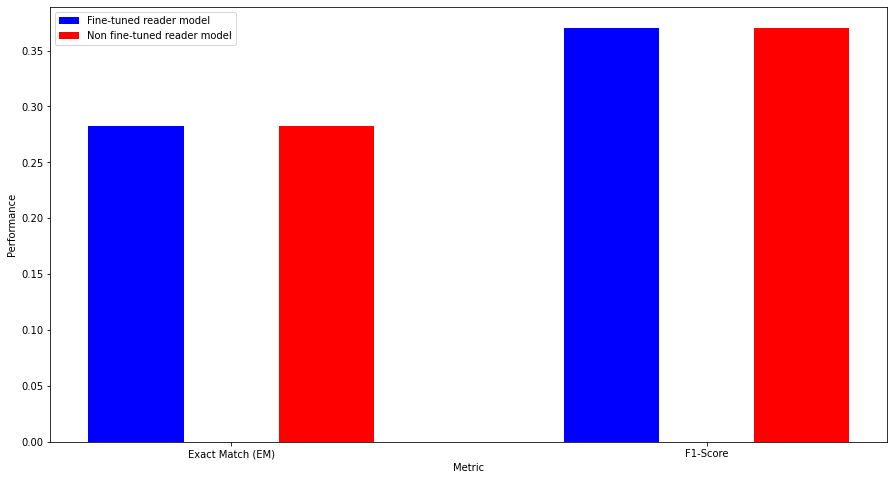

In [ ]:
# comparison of results with non fine-tuned reader model
print(f"Average EM score of the finetuned reader model: {EM_tuned / len(subjqa_test)}")
print(f"Average EM score of the non-finetuned reader model: {EM_nonTuned / len(subjqa_test)}\n")

print(f"Average F1 score of the finetuned reader model: {np.mean(F1_tuned)}")
print(f"Average F1 score of the non-finetuned reader model: {np.mean(F1_nonTuned)}\n")

# plot results
x = np.arange(2) 
width = 0.2
plt.figure(figsize=(15, 8))
plt.bar(x-0.2, [EM_tuned / len(subjqa_test), np.mean(F1_tuned)], width, color='blue') 
plt.bar(x+0.2, [EM_nonTuned / len(subjqa_test), np.mean(F1_nonTuned)], width, color='red') 
plt.xticks(x, ['Exact Match (EM)', 'F1-Score']) 
plt.xlabel("Metric") 
plt.ylabel("Performance") 
plt.legend(["Fine-tuned reader model", "Non fine-tuned reader model"]) 
plt.show()

Evaluating the final results, it can be seen that quite a good performance given the difficulty of the problem and (noisy) dataset at hand was achieved.

Interestingly, the results between the fine-tuned and non fine-tuned reader model do not differ at all. This might be the case because the respective predictions (spans) were pretty clear and/or the reader model itself is very stable such that fine-tuning over a few epochs does not alter its predictions.
Also, the initial reader model is already fine-tuned on SQuAD 2.0, which might be another contributing factor.